In [ ]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import sys
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from sklearn.utils.extmath import randomized_svd
import scipy as sp
import scipy.spatial
import scipy.spatial.distance as distance
import nltk
import wordcloud
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from time import time
import numpy as np
from sklearn import datasets
from sklearn.manifold import MDS,TSNE
from scipy.stats.mstats import zscore
import matplotlib.pyplot as plt


<class 'numpy.ndarray'>
center Xdata 
center Xdata 
 fit funciont 


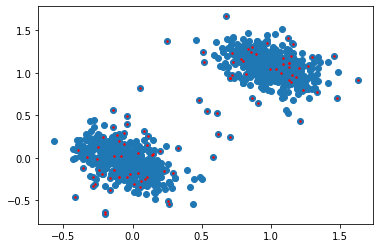

In [ ]:
import scipy
epsilon = 1e-7
class Lamp():
    def __init__(self, Xdata = None, control_points = None, weights = None, label=False, scale=True, dim = 2):
        #self.Xdata = Xdata
        self.data = None
        self.mapped = None
        self.control_points = control_points
        self.control_points_data = None
        self.weights = weights
        self.dim = dim
        self.labels = None
        self.label = label
        self.scale = scale
        self.data_center = None
        self.control_points_center = None
        self.U = None
        self.S = None
        self.V = None
        #print(self.Xdata)
        if Xdata is not None:
            print(type(Xdata))
            try:
                if type(Xdata) is not np.ndarray:
                    raise TypeError()

                if label is False:
                    self.center(Xdata,o_c_s='o')
                else:
                    self.center(Xdata[:,:-1],o_c_s='o')
                    self.labels = Xdata[:,-1].astype(int)

            except (AttributeError, TypeError):
                print('----- LAMP Error -----')
                print('Xdata must be a Numpy Array')
                sys.exit()

        if control_points is not None:
            try:
                if type(control_points) is not np.ndarray:
                    raise TypeError()

            except (AttributeError, TypeError):
                print('----- LAMP Error -----')
                print('control_points must be a Numpy Array')
                sys.exit()

            self.center(control_points,o_c_s='c')
#########
    def fit(self,Xdata=None):
        ''' decide if the mapping should be trigger with or without control points'''
        print(" fit funciont ")
        if Xdata is not None:
            try:
                if type(Xdata) is not np.ndarray:
                    raise TypeError()
                if self.data is not None:
                    if self.label is True:
                        self.center(Xdata[:,:-1],o_c_s='s')
                        self.labels =Xdata[:,-1].astype(int)
                    else:
                        self.center(Xdata,o_c_s='s')
                else:
                    if self.label is True:
                        self.center(Xdata[:,:-1],o_c_s='o')
                        self.labels =Xdata[:,-1].astype(int)
                    else:
                        self.center(Xdata,o_c_s='o')
            except (AttributeError, TypeError):
                print('----- LAMP Error -----')
                print('Type Error: Xdata must be a Numpy Array')
                sys.exit()
        else:
            try:
                if self.data is None:
                    raise ValueError()
            except ValueError:
                print('----- LAMP Error -----')
                print('No data to map')
                sys.exit()
        if self.control_points is not None:
            if (self.scale is True) and (self.S is None):
                self.scale_control_points()
            self.map()
            if self.scale is True:
                self.unscale()
            mapped = self.mapped + self.control_points_center
            if self.label is True:
                mapped = np.hstack((mapped,self.labels.reshape(self.labels.shape[0],1)))
        else:
            self.control_points_free_mapping()  # To be implemented soon
            mapped = self.mapped
        return(mapped)

#########
    def map(self):
        ''' mapping using control points '''
        n,k = self.data.shape
        m = self.control_points.shape[0]
        self.mapped = np.zeros((n,self.dim))
        ctp_mapped = self.control_points[:,:-1]
        ctp_data = self.control_points_data
        if self.weights is None:
            self.weights = distance.cdist(self.data,ctp_data)
            self.weights = 1.0/(self.weights+epsilon)
        for i in range(n):
            alpha = np.sum(self.weights[i])
            x_tilde = np.dot(ctp_data.T,self.weights[i].T)/alpha
            y_tilde = np.dot(ctp_mapped.T,self.weights[i].T)/alpha
            x_hat = ctp_data - x_tilde
            y_hat = ctp_mapped - y_tilde
            D = np.diag(np.sqrt(self.weights[i]))
            A = np.dot(D,x_hat)
            B = np.dot(D,y_hat)
            U,s,V = randomized_svd(np.dot(A.T,B), n_components=2, random_state=None)
            M = np.dot(U,V)
            self.mapped[i] = np.dot((self.data[i] - x_tilde),M)+y_tilde

#########
    def center(self,X,o_c_s='o'):
        '''o_c_s distriminate between original data (o), control points (c), and streaming data (s)'''
        print("center Xdata ")
        if o_c_s == 'o':
            Xmean = np.average(X, axis=0)
            self.data_center = Xmean
            self.data = np.subtract(X,Xmean)

        if o_c_s == 'c':
            ctp_ids = X[:,-1].astype(int)
            self.control_points_data = self.data[ctp_ids]
            Xmean = np.average(X[:,0:2], axis=0)
            self.control_points_center = Xmean
            centered = np.subtract(X[:,0:2],Xmean)
            self.control_points = np.hstack((centered,X[:,-1].reshape(-1,1)))

        if o_c_s == 's':
            self.data = np.subtract(X,self.data_center)

#########
    def scale_control_points(self):
        ctp_ids = self.control_points[:,-1].astype(int)
        ctp_mapped = self.control_points[:,:-1]
        ctp_data = self.data[ctp_ids]
        Uo,So,Vo = randomized_svd(ctp_data.T, n_components=2, random_state=None)
        Uc,Sc,Vc = randomized_svd(ctp_mapped.T, n_components=2, random_state=None)
        DSo = np.diag(So)
        self.control_points[:,:-1] = np.dot(np.dot(Uc,DSo),Vc).T

        self.U = Uc
        self.S = np.diag(Sc)
        self.So = np.diag(So)
        self.V = Vc

#########
    def unscale(self):
        proj = np.dot(self.U.T,self.mapped.T)
        Sinv = np.zeros((2,2))
        Sinv[0,0] = 1.0/self.So[0,0]
        Sinv[1,1] = 1.0/self.So[1,1]
        proj_unscaled = np.dot(Sinv,proj)
        self.mapped = np.dot(self.U,np.dot(self.S,proj_unscaled)).T

#########
    def control_points_free_mapping(self):
        ''' Mapping without control points '''
        def stress(p,pt,d):
            cost = 0
            for i in range(3):
                cost += ((p[0]-pt[i,0])**2+(p[1]-pt[i,1])**2-d[i])**2
            return(cost)

        max_dist = 1e8
        n = self.data.shape[0]
        knn = 5
        self.mapped = np.zeros((n,self.dim))

        D = cdist(self.data,self.data)

        # finding the 3 first points that give rise to the inicial triangle

        ### starting with the farthest 2 points
        idx_flat = np.argmax(D)
        idx_i = idx_flat//n
        idx_j = idx_flat - n*idx_i

        d01 = D[idx_i,idx_j]
        d01 += epsilon
        D[idx_i,idx_j] = 0
        D[idx_j,idx_i] = 0
        processed_points = [idx_i,idx_j]

        D_processed = D[processed_points]
        idx_flat = np.argmax(D_processed)
        idx_i = idx_flat//n
        idx_j = idx_flat - n*idx_i
        d02 = D[processed_points[0],idx_j]**2 + epsilon
        d12 = D[processed_points[1],idx_j]**2 + epsilon
        D[processed_points,idx_j] = 0
        D[idx_j,processed_points] = 0
        processed_points.append(idx_j)

        # computing the initial triangle
        x = (-d12+d02+d01**2)/(2.0*d01)
        y = np.sqrt(d02-x**2)
        ltemp = [(0,0),(d01,0),(x,y)]
        proj_tri = np.asarray(ltemp)
        self.mapped[processed_points] = proj_tri[:]


        # computing k more initial points
        for i in range(3,knn):
            D_processed = D[processed_points]
            idx_flat = np.argmax(D_processed)
            idx_i = idx_flat//n
            idx_j = idx_flat - n*idx_i
            d = np.asarray([D[processed_points[0],idx_j]**2+epsilon, D[processed_points[1],idx_j]**2+epsilon, D[processed_points[2],idx_j]**2+epsilon])
            D[processed_points,idx_j] = 0
            D[idx_j,processed_points] = 0
            processed_points.append(idx_j)

            res = minimize(stress, np.asarray([0,0]),args=(proj_tri,d))
            self.mapped[idx_j] = res.x

        D = D + max_dist*np.identity(n)
        for idx_j in processed_points:
            D[processed_points,idx_j] = max_dist
            D[idx_j,processed_points] = max_dist

        # mapping the data set
        weights = np.zeros((knn,))
        for i in range(knn,n):
            D_processed = D[processed_points]
            idx_flat = np.argmin(D_processed)
            idx_i = idx_flat//n
            idx_j = idx_flat - n*idx_i

            neighbors_ids = np.argpartition(D[idx_j,processed_points],knn-1)[:knn]
            ctp_ids = [processed_points[j] for j in neighbors_ids]
            weights[:] = D[idx_j,ctp_ids]
            weights = 1.0/(weights+epsilon)
            ctp_data = self.data[ctp_ids]
            ctp_mapped = self.mapped[ctp_ids]

            alpha = np.sum(weights)
            x_tilde = np.dot(ctp_data.T,weights.T)/alpha
            y_tilde = np.dot(ctp_mapped.T,weights.T)/alpha
            x_hat = ctp_data - x_tilde
            y_hat = ctp_mapped - y_tilde
            S = np.diag(np.sqrt(weights))
            A = np.dot(S,x_hat)
            B = np.dot(S,y_hat)
            U,s,V = randomized_svd(np.dot(A.T,B), n_components=2, random_state=None)
            M = np.dot(U,V)
            self.mapped[idx_j] = np.dot((self.data[idx_j] - x_tilde),M)+y_tilde

            D[processed_points,idx_j] = max_dist
            D[idx_j,processed_points] = max_dist
            processed_points.append(idx_j)
if __name__ == "__main__":

    # generating data by drawning points from 2 gaussian in R^20
    D = np.random.multivariate_normal(np.zeros((20,)), 0.1*np.identity(20,dtype=float), 500)
    D = np.vstack((D,np.random.multivariate_normal(np.ones((20,)), 0.1*np.identity(20,dtype=float), 500)))


    #print(D)
    # defining control points by projecting orthogonally a random subset of D in R^2
    sample_ids = np.random.randint(low=0,high=1000,size=(100,))  # getting 100 random points in D as control points
    control_points = D[sample_ids,0:2]                           # coordinates of control points
    control_points = np.hstack((control_points,sample_ids.reshape(-1,1)))  # including ids of original points as the last column of control_points
    lamp = Lamp(Xdata=D,control_points=control_points)
    proj = lamp.fit()
    plt.scatter(proj[:,0],proj[:,1])
    plt.scatter(control_points[:,0],control_points[:,1],c='r',s=2)
    plt.show()

In [ ]:
#procesamiento ....
!pip install -U spacy
!python -m spacy download es

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-10-25 19:56:22.797074: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'es' are deprecated. Please use the
full pipeline package name 'es_core_news_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.9 MB 24.9 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [ ]:
def get_list_filenames(list_paths):
    list_names = []
    divider = "/"
    if len(list_paths) > 0:
        if "\\" in list_paths[0]:
            divider = "\\"
    for file in list_paths:
        filename = file.split(divider)[-1]
        list_names = list_names + [filename[:-4]]
    return list_names

In [ ]:

from multiprocessing import Pool
import os
from os import path
from glob import glob


def find_ext(folder, ext):
    return glob(path.join(folder, "*.{}".format(ext)))

nombres_txt = get_list_filenames(find_ext("/content/drive/MyDrive/PDF de las palabras claves/PDF-TEXTOS_LIMPIOS_2", "txt"))
print(nombres_txt)

['130-Texto del artículo-269-1-10-20161119 (1)', 'Salazar_ff (1)', '16115-Texto del artículo-64001-2-10-20170215 (1)', '1150-Texto del artículo-2459-1-10-20171110', '3519-Texto del artículo-10351-1-10-20201229', '14603-Texto del artículo-58054-2-10-20160302', '251-Texto del artículo-5198-1-10-20211219', '380-Texto del artículo-770-1-10-20161123', 'Filosofía y política en el Perú estudio del pensamiento de Víctor Raúl Haya de la Torre, José Carlos Mariátegui, Víctor Andrés Belaunde', 'Anchante_aj', 'Martinez_lm - Resumen', 'FLORES_MP', 'Salazar_ff', 'MONOGRAFÍA - Aucatoma Moscoso, Jorge Luis - FCSyH', '4737-Texto del artículo-15423-1-10-20220203', 'ALVARADO_LUNA_PATRICIO_VIRREY_JOAQUIN', '61-Texto del artículo-829-1-10-20190620', 'Inca Garcilaso de la Vega - Vida e historia', '823-Texto del artículo-2110-1-10-20200330', 'Rosario_pe', 'HIpiesj', 'UNFV_PaucarLimaylla_JosueCentella_Título Profesional_2019', '17017-Texto del artículo-67586-1-10-20170425', '4454-Texto d

In [ ]:
import numpy as np
#corpus=abrir_txt_corpus("/content/drive/MyDrive/PDF de las palabras claves/PDF_TEXTOS_LIMPIOS","21757-Texto del artículo-86012-1-10-20200204")
#words_set = set()

import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from nltk.stem import SnowballStemmer
from nltk.stem import *
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
nlp = spacy.load('es_core_news_sm')
nltk.download('punkt')
nltk.download('stopwords')
def abrir_txt_corpus(ruta_txt,nombre_txt):
  read_txt=ruta_txt+'/'+nombre_txt+".txt"
  with open(read_txt, "r") as fileTK:
    corpus = fileTK.read().replace("\n", "") # corpus is all the text in the file
    #docs=corpus.splitlines()
  return corpus


def corpus_txt_limpios(ruta, nombres):
  corpus=[]
  [corpus.append(abrir_txt_corpus(ruta,n) ) for n in nombres]
  print(corpus)
  return corpus

corpus=corpus_txt_limpios("/content/drive/MyDrive/PDF de las palabras claves/PDF_TEXTOS_LIMPIOS",nombres_txt)
#print(len(example_co))

def vector_tfidf(corpus,nombres_txt):
  stop = stopwords.words('spanish')
  tr_idf_model  = TfidfVectorizer(stop_words=stop,
    #ngram_range=(2,2), # bigrams
    use_idf=True)
  tf_idf_vector = tr_idf_model.fit_transform(corpus)
  tf_idf_array=tf_idf_vector.toarray()
  #print(tf_idf_array)
  words_set = tr_idf_model.get_feature_names_out()
  print(len(words_set))
  #[print(x) for x in words_set]
  df_tf_idf = pd.DataFrame(tf_idf_array, columns = words_set,index=nombres_txt)
  return df_tf_idf
#print(abrir_txt_corpus("/content/drive/MyDrive/PDF de las palabras claves/PDF_TEXTOS_LIMPIOS","21757-Texto del artículo-86012-1-10-20200204"))
vector=vector_tfidf(corpus,nombres_txt)
#amozonia
stemmer = SnowballStemmer('spanish')
x_bus=stemmer.stem('amazonia')
print(x_bus)
print(vector)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



51378
amazoni
                                                     aa  aaa  aaaraj  aab  \
3519-Texto del artículo-10351-1-10-20201229   0.000000  0.0     0.0  0.0   
14603-Texto del artículo-58054-2-10-20160302  0.000000  0.0     0.0  0.0   
251-Texto del artículo-5198-1-10-20211219     0.025265  0.0     0.0  0.0   
380-Texto del artículo-770-1-10-20161123      0.000000  0.0     0.0  0.0   
30                                             0.000000  0.0     0.0  0.0   
...                                                 ...  ...     ...  ...   
130-Texto del artículo-269-1-10-20161119      0.000000  0.0     0.0  0.0   
62-Texto del artículo-210-1-10-20150901       0.000000  0.0     0.0  0.0   
2628-Texto del artículo-6356-2-10-20200108    0.000000  0.0     0.0  0.0   
UDEP_Cien años despues_Mónica Junchaya       0.000000  0.0     0.0  0.0   
253T20190605_TC                                0.000000  0.0     0.0  0.0   

                                               aabb  aabba  a

<class 'numpy.ndarray'>
center Xdata 
center Xdata 
 fit funciont 


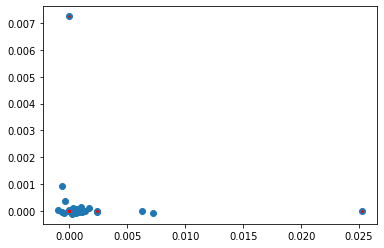

In [ ]:

numpy_array = vector.to_numpy()

x=len(numpy_array[:,0])
y=len(numpy_array[:,1])
#numpy_array= np.vstack((numpy_array,np.random.multivariate_normal(np.zeros(x),np.eye(x),size=y)))
sample_ids = np.random.randint(low=0,high=x,size=(100,))  # getting 100 random points in D as control points
control_points = numpy_array[sample_ids,0:2]                           # coordinates of control points
control_points = np.hstack((control_points,sample_ids.reshape(-1,1)))  # including ids of original points as the last column of control_points
lamp = Lamp(Xdata=numpy_array,control_points=control_points)
proj = lamp.fit()
plt.scatter(proj[:,0],proj[:,1])
plt.scatter(control_points[:,0],control_points[:,1],c='r',s=2)
plt.show()



<class 'numpy.ndarray'>
center Xdata 
 fit funciont 
Took 2.4556775093078613s


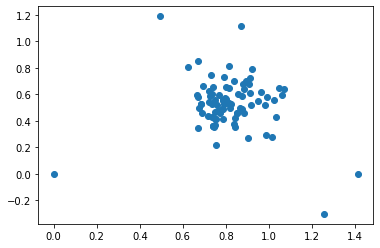

In [ ]:
##### using Lamp
ts = time()
lamp_proj = Lamp(Xdata = numpy_array, label=False)
data_proj = lamp_proj.fit()
print('Took {}s'.format(time() - ts))

plt.scatter(data_proj[:,0],data_proj[:,1])
#plt.scatter(data_proj[:,0],data_proj[:,1],c=data[:,-1])
plt.show()

In [ ]:
def get_relevant_documents(vector_tf_idf, keywords, stemmer=None):
    list_keywords = keywords.split(" ")
    selected_documents = pd.DataFrame()

    if stemmer is not None:
        for i in range(0, len(list_keywords)):
            list_keywords[i] = stemmer.stem(list_keywords[i])
    list_keywords = list(dict.fromkeys(list_keywords))
    print(list_keywords)
    list_keywords = [ word for word in list_keywords if word in vector_tf_idf.columns ]
    print(list_keywords)
    if len(list_keywords) > 0:
        selected_documents = vector_tf_idf[list_keywords]
        for word in list_keywords:
            selected_documents = selected_documents.loc[selected_documents[word] > 0]
        #tmp = tmp.sort_values(by=[list_keywords[0]], ascending=False)
        #print(selected_documents)
    return list(selected_documents.index.values), selected_documents


In [ ]:
lista,matriz=get_relevant_documents(vector, "incas",SnowballStemmer("spanish"))
print(matriz)

['incas']
['incas']
                                                       incas
251-Texto del artículo-5198-1-10-20211219          0.005325
Salazar_ff                                          0.206392
Salazar_ff (1)                                      0.206392
MONOGRAFÍA - Aucatoma Moscoso, Jorge Luis - FCSyH  0.002051
4737-Texto del artículo-15423-1-10-20220203        0.206309
Rosario_pe                                          0.002472
UNFV_PaucarLimaylla_JosueCentella_Título Profe...  0.000897
823-Texto del artículo-2110-1-10-20200330          0.040347
Anchante_aj                                         0.009071
DI_FRANCO_OCHOA_CARLA_UN_PALACIO                    0.037223
2138-Texto del artículo-5082-1-10-20190528         0.007522
Aguila_pa                                           0.000637
Rodriguez_cj                                        0.006279
pensamiento político de gonzalez prada             0.001977
REYDECASTRO_ARENA_ALEJANDRO_ELPENSAMIENTO           0.006495
Rive

In [ ]:
def short_filenames(array_names):
  array_shortnames=[]
  for i in array_names:
    c=len(i)-2
    if(len(i)<=4):
       array_shortnames.append(i[:3])
    else:
      array_shortnames.append(i[:3]+i[c:])
  return array_shortnames


In [ ]:
##### using Lamp

numpy_array_relevant=matriz.to_numpy()
data_top_matriz = matriz.head()
print(matriz.head().index.to_numpy())
# list(data_top) or
annotations=["251","salz","salz1","aucatoma","4737","rosario","unfv","823","anch","difr","2138","agul","rod","gz-p",
             "cast-arena","riv","2016","4479","sch-fz","teran","20497","vill","doc","doc1","achuar","1356","moron","2653","2628","2tc"]
ts = time()
print(short_filenames(annotations))

['251-Texto del artículo-5198-1-10-20211219' 'Salazar_ff'
 'Salazar_ff (1)' 'MONOGRAFÍA - Aucatoma Moscoso, Jorge Luis - FCSyH'
 '4737-Texto del artículo-15423-1-10-20220203']
['251', 'sal', 'salz1', 'aucma', '473', 'rosio', 'unf', '823', 'anc', 'dif', '213', 'agu', 'rod', 'gz-', 'casna', 'riv', '201', '447', 'schfz', 'teran', '20497', 'vil', 'doc', 'doc', 'achar', '135', 'moron', '265', '262', '2tc']


<class 'numpy.ndarray'>
center Xdata 
 fit funciont 
[0.00532467 0.20639184 0.20639184 0.00205118 0.20630879 0.00247176
 0.00089675 0.04034681 0.00907061 0.03722267 0.00752199 0.00063749
 0.00627937 0.00197715 0.00649471 0.00502603 0.00199531 0.01166826
 0.00197177 0.00251513 0.01158767 0.0069466  0.00502476 0.09732472
 0.00212449 0.01229189 0.00342058 0.00789103 0.01154796 0.00506559]


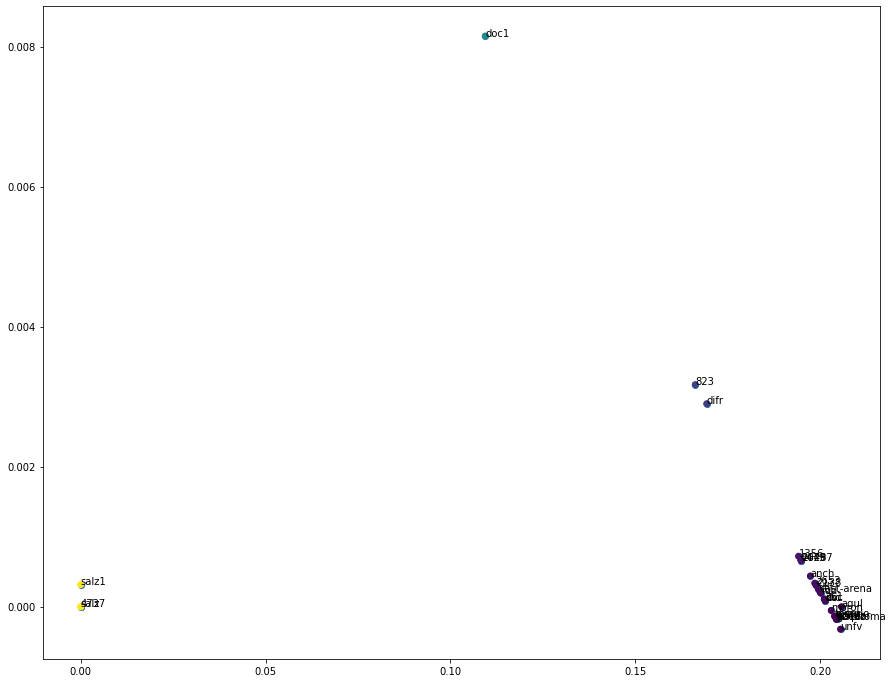

In [ ]:

lamp_proj = Lamp(Xdata = numpy_array_relevant)
data_proj = lamp_proj.fit()
#graficar con nombres para cada punto, nombre del documento para cada punto
x=data_proj[:,0]
y=data_proj[:,1]
plt.figure(figsize=(15,12))
plt.scatter(x,y)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
print(numpy_array_relevant[:,-1])
#salida un arreglo de nombres cortos, y completos, y los puntos proyeccion
# nombre dos primeros y dos ultimos caracteres

plt.scatter(data_proj[:,0],data_proj[:,1],c=numpy_array_relevant[:,-1])
plt.show()
# por 1000

In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import seaborn as sns
